### Note
I use the same premise of work as the previous experiment and the same steps.  as before I have implemented some functions with the purpose of inserting them (in the future) into an external file and recalling them via 'import'. I immediately define them to lighten the reading of the session. Among them there is also the new loss function, an Euclidean Distance Loss. Compared to the last experiment, I changed the dimensions of the dataset to 12,500 examples to speed up the training operations and evaluate the loss function.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K 


def euc_loss(y_true, y_pred):
  '''  
  Arguments:
  y_true -- tensor with expected Y
  y_pred -- tensor with predicted Y
  
  Returns:
  euc_dist -- scalar
  '''
  euc_dist = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
  return euc_dist
  
# We define one of the reference metrics to analyze our results
# the Intersection over Union that measures the correspondence 
# of our predictions with the actual bounding boxes

def IoU(box1, box2):
  '''  
  Arguments:
  box1 -- first box, with coordinates (x, y, w, h)
  box2 -- second box, with coordinates (x2, y2, w2, h2)
  
  Returns:
  iou -- scalar
  '''    
  [x, y, w, h] = box1
  [x2, y2, w2, h2] = box2
    
  # Intesection area 
  xi1 = np.maximum(x, x2)
  yi1 = np.maximum(y, y2)
  xi2 = np.minimum(x+w, x2+w2)
  yi2 = np.minimum(y+h, y2+h2)
  xi = np.maximum(0., xi2-xi1)
  yi = np.maximum(0., yi2-yi1)
  
  inter_area = np.multiply(xi,yi)

  # Union area
  box1_area = (w*h)
  box2_area = (w2*h2)
  union_area = box1_area+box2_area-inter_area
  
  # Calculation of IoU
  iou = inter_area/union_area

  return iou

# The average IoU of the a whole dataset 
def mean_IoU(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, N_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, N_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  [n_examples, N_bb] = expe_bboxes.shape[:2] 
  IoU_test = np.zeros((n_examples, N_bb)) 
  iou_global = 0

  for i in range(dim_test):
    for j in range(N_bb):

      [x , y, w, h] = pred_bboxes[i, j, 1:] 
      [x2, y2, w2, h2] = expe_bboxes[i, j, 1:] 

      IoU_test[i,j] = IoU([x,y,w,h], [x2,y2,w2,h2])

  iou_global = np.mean(IoU_test)
  return iou_global

def visual_example(imgTest, side_dim, N_bb, pred_bboxes, expe_bboxes):  
  '''  
  Arguments:
  imgTest -- np.array(32,32,3), an image
  N_bb -- scalar, number of bounding bboxes for each example
  expe_bboxes -- np.array(5), expected bounding boxes  
  pred_bboxes -- np.array(5), predicted bounding boxes 
  
  Returns:
  None
  ''' 
  
  N_bb = expe_bboxes.shape[0]

  # We look at the objects contained in it...
  fig, ax = plt.subplots(1)
  ax.imshow(imgTest, origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

  # ...and the bounding boxes predicted by the algorithm
  for i in range (N_bb):
    [x , y, w, h] = pred_bboxes[i, 1:] 
    [x2, y2, w2, h2] = expe_bboxes[i, 1:] 
    
    rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.4', fc='none')

    dida = 'IoU: ' + '{:0.3f}'.format(IoU([x,y,w,h], [x2,y2,w2,h2]))
    plt.annotate(dida, (x + w , y - 0.8), color='r')

    print('Object: ', i+1)
    print('B-box confidence:', Pc)
    print('B-box coordinates:', '[{:0.2f}'.format(x), '{:0.2f}'.format(y), '{:0.2f}'.format(w), '{:0.2f}]'.format(h))
    print('Object coordinates:', '[{:0.2f}'.format(x2), '{:0.2f}'.format(y2), '{:0.2f}'.format(w2), '{:0.2f}]'.format(h2))

    ax.add_patch(rect)

  plt.show()


def visual_metric(train_ex, m_iou, N_ep, Batchs, history, metric):
  print('----> Datatset IoU:', m_iou)
  print('      Dim. train:', train_ex, 'examples')
  print('      Epochs:', N_ep, '- mini-batches:', Batchs)

  # Plot training & validation accuracy values
  plt.plot(history[metric])
  plt.plot(history['val_' + metric])
  plt.title('Model ' + metric)
  plt.ylabel(metric)
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [0]:
def iou(y_true, y_pred, label: int):
    """
    Return the Intersection over Union (IoU) for a given label.
 
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
        c: the label to return the IoU for
 
    Returns:
        the IoU for the given label
 
    """
    # extract the label values using the argmax operator then
    # calculate equality of the predictions and truths to the label
    y_true = K.cast(K.equal(K.argmax(y_true), label), K.floatx())
    y_pred = K.cast(K.equal(K.argmax(y_pred), label), K.floatx())
    # calculate the |intersection| (AND) of the labels
    intersection = K.sum(y_true * y_pred)
    # calculate the |union| (OR) of the labels
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    # avoid divide by zero - if the union is zero, return 1
    # otherwise, return the intersection over union
    return K.switch(K.equal(union, 0), 1.0, intersection / union)
 
 
def build_iou_for(label: int, name: str=None):
    """
    Build an Intersection over Union (IoU) metric for a label.
 
    Args:
        label: the label to build the IoU metric for
        name: an optional name for debugging the built method
 
    Returns:
        a keras metric to evaluate IoU for the given label
         
    Note:
        label and name support list inputs for multiple labels
 
    """
    # handle recursive inputs (e.g. a list of labels and names)
    if isinstance(label, list):
        if isinstance(name, list):
            return [build_iou_for(l, n) for (l, n) in zip(label, name)]
        return [build_iou_for(l) for l in label]
 
    # build the method for returning the IoU of the given label
    def label_iou(y_true, y_pred):
        """
        Return the Intersection over Union (IoU) score for {0}.
 
        Args:
            y_true: the expected y values as a one-hot
            y_pred: the predicted y values as a one-hot or softmax output
 
        Returns:
            the scalar IoU value for the given label ({0})
 
        """.format(label)
        return iou(y_true, y_pred, label)
 
    # if no name is provided, us the label
    if name is None:
        name = label
    # change the name of the method for debugging
    label_iou.__name__ = 'iou({})'.format(name)
 
    return label_iou
 
def mean_iou(y_true, y_pred):
    """
    Return the Intersection over Union (IoU) score.
 
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
 
    Returns:
        the scalar IoU value (mean over all labels)
 
    """
    # get number of labels to calculate IoU for
    num_labels = 4
    # initialize a variable to store total IoU in
    total_iou = K.variable(0)
    # iterate over labels to calculate IoU for
    for label in range(num_labels):
        total_iou = total_iou + iou(y_true, y_pred, label)
    # divide total IoU by number of labels to get mean IoU
    return total_iou / num_labels

# Object detection in images - Model 1

(tags: CNN, Object detection)

<small>This work was inspired by [Johannes Rieke article on Medium](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) and by [Andrew Ng's Specialization Course on Deep Learning](https://www.coursera.org/specializations/deep-learning).</small>

Rieke's work is interesting for the simplicity with which he creates a trainingset for our purpose - that is, developing bounding boxes that identify particular objects in an image. I dedicate myself in particular to the identification of several objects in the same image.

Rieke highlights a big risk: in the identification of N objects, the neural network ends up with not specializing and instead it develops 'average' bounding boxes - more or less equal - useless for our purpose. To solve this problem he proposes an algorithm for swapping the example's targets label between one epoch and another. A mechanism that did not convince me for two reasons:

- it considerably weighs the algorithm on a computational level (at the end of epoch the predictions of the network with the target values are compared).
- in the tests I did I could not get out of a sort of perpetual oscillation and at every epoch the percentage of swaps remained almost unchanged.

Conceptually starting from the work of Rieke I propose a solution that makes clear the importance of a preprocessing of our dataset. In fact, I create an order in the target values of our trainingset. I take as reference point the distance from one of the edges of the image (the origin in a coordinate system). 

As you can see it is an elegant solution that solves the problem upstream. Later I dedicate myself to improving the efficiency of the neural network.



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from keras import optimizers
import pickle

%matplotlib inline

We create a simple image dataset. Each image will have a maximum size of 32x32 and will contain up to a maximum of N_bb objects (rectangles) with different shades of color. Their size will vary between a minimum of 1x1 and a maximum of 8x8. [To implement : If the color gradation (0-255) is less than or greater than a certain threshold (in our case <64), the object must not be detected.]

At the same time we define our bounding boxes. We will use 5 coordinates: a 'Pc', which indicates the percentage of confidence in the presence of an object; 'x' and 'y', for the spatial position of the top-left vertex and 'w' and 'h' for the extension (width and height).

In [0]:
N_imgs = 12500

# imagines side dimension
side_dim = 32 

# objects min/max side dimensions
obj_min_dim = 2
obj_max_dim = 8 

# number of objects
N_bb = 4 

# color thresholds
min_threshold = 0
max_threshold = 124

# confidence threshold
Pc_th = .0

# inizialization of images with a light gray color (just for aesthetic reasons)
imgs = np.ones((N_imgs, side_dim, side_dim,3)) * .9 

# inizialization of bounding boxes
bounding_boxes = np.zeros((N_imgs, N_bb, 5))


In [0]:
# inizialization of origin distance array
distance = np.zeros((N_imgs, N_bb))

# creation of objects in images and relative bounding boxes

for N_img in range(N_imgs):
    for i_ogg in range(N_bb):
        w = np.random.randint(obj_min_dim, obj_max_dim)
        h = np.random.randint(obj_min_dim, obj_max_dim)
        x = np.random.randint(0, side_dim - w)
        y = np.random.randint(0, side_dim - h)
          
        R = (np.random.randint(min_threshold, max_threshold)) / 255
        G = (np.random.randint(min_threshold, max_threshold)) / 255
        B = (np.random.randint(min_threshold, max_threshold)) / 255
        
        imgs[N_img, y:y+h, x:x+w, 0] = R 
        imgs[N_img, y:y+h, x:x+w, 1] = G 
        imgs[N_img, y:y+h, x:x+w, 2] = B 
        

        Pc = 1. # for the moment we use for all target value Pc = 1
        bounding_boxes[N_img, i_ogg] = [Pc, x, y, w, h]   
        
        # we calculate the distance from the origin for each Bounding Box
        distance[N_img, i_ogg] = np.sqrt(np.square(x+(w/2))+ np.square(y+(h/2)))


## Observation and pre-processing
First we analyze our datasets and start preprocessing them

In [5]:
# Let's look at the size of the Numpy arrays for images and bboxes 
print('Dimension of images array:', imgs.shape)
print('Dimension of BBoxes array:', bounding_boxes.shape)
print('Dimension of distance array:', distance.shape)

Dimension of images array: (12500, 32, 32, 3)
Dimension of BBoxes array: (12500, 4, 5)
Dimension of distance array: (12500, 4)


Imagine n. 2460


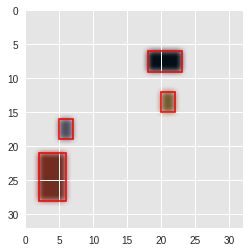

In [6]:
# We take a random image of our training set
im = np.random.randint(N_imgs)
print('Imagine n.', im)

# Let's look the objects contained in it...
fig, ax = plt.subplots(1)
ax.imshow(imgs[im], origin = 'upper', interpolation = 'quadric', extent=[0, side_dim, side_dim, 0])

# ...and the corresponding bounding boxes
for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

# we consider only a percentage of confidence above the Pc_th
# (in our datasets we have Pc with values 0 or 1) but later
# Pc will assume probabilistic values between 0 and 1
  if Pc >= Pc_th:
    rect = patches.Rectangle((x, y) , w, h, ec='r', lw='1.6', fc='none')
    ax.add_patch(rect)

plt.show()

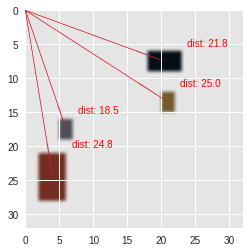

In [7]:
# We look at the image again, this time highlighting the distance of the objects from the origin ...
fig, ax = plt.subplots(1)

ax.imshow(imgs[im], origin = 'upper', interpolation = 'hanning', extent=[0, side_dim, side_dim, 0])

for i in range (N_bb):
  [Pc, x, y, w, h] = bounding_boxes[im, i]

  if Pc >= Pc_th:
    line = patches.Arrow(0, 0, x+(w/2), y+(h/2), .2, ec='r') 
    ax.add_patch(line)
    dida = 'dist: ' + '{:0.1f}'.format(distance[im,i])
    plt.annotate(dida, (x + w + 0.8 , y - 0.8), color='r')

plt.show()

We rearrange the bounding boxes based on the distance from the origin of the objects

In [0]:
order = np.zeros((N_imgs, N_bb), dtype=int)
bboxes = np.zeros(bounding_boxes.shape)

for i in range(N_imgs):
  order[i] = np.argsort(distance[i]) 
  for j in range(N_bb):
    bboxes[i,j] = (bounding_boxes[i, order[i,j]])

### Save Datasets
Now we save our datasets for future uses

In [0]:
dataset_name = str(int(N_imgs/1000))

In [10]:

# To save datasets
np.save('181112_Images_' + dataset_name, imgs)
np.save('181112_Bboxes_' + dataset_name, bboxes)

# To load datasets
'''
imgs = np.load('Images_' + dataset_name + '.npy')
bboxes = np.load('Bboxes_' + dataset_name + '.npy')
print(imgs.shape, bboxes.shape)
'''

"\nimgs = np.load('Images_' + dataset_name + '.npy')\nbboxes = np.load('Bboxes_' + dataset_name + '.npy')\nprint(imgs.shape, bboxes.shape)\n"

Let's start thinking in terms of Machine Learning. 
So we normalize the pixel values contained in our images to have values between -1 and 1 and transfer them to the input X values.


In [11]:
X = (imgs - np.mean(imgs)) / np.std(imgs)
print(X.shape, np.mean(imgs), np.std(imgs))

Y = bboxes.reshape(N_imgs, -1) 
print(Y.shape)

(12500, 32, 32, 3) 0.8497362672079277 0.1791630750977642
(12500, 20)


Below we see our X values shape

In [12]:
print('Images example', im, 'has shape:\n', X[im].shape, '\n')

Images example 2460 has shape:
 (32, 32, 3) 



And then we observe one of our Y target values

In [13]:
print('...and the target values Y are:\n', Y[im])

...and the target values Y are:
 [ 1.  5. 16.  2.  3.  1. 18.  6.  5.  3.  1.  2. 21.  4.  7.  1. 20. 12.
  2.  3.]


We have a homogeneous dataset of the N_imgs elements that we now share in Training set, Validation set, and Test set in relation 80%, 10%, 10%.

In [14]:
i = int(0.8 * N_imgs)
j = int(0.1 * N_imgs)

X_train = X[:i]
Y_train = Y[:i]
train_ex = X_train.shape[0]

X_val = X[i:i+j]
Y_val = Y[i:i+j]
val_ex = X_val.shape[0]

X_test = X[i+j:]
Y_test = Y[i+j:]
test_ex = X_test.shape[0]

dim_test = j # useful for the future 

print('Below the dimensions of X and Y for Training set, Validation set, and Test set respectively\n')
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

Below the dimensions of X and Y for Training set, Validation set, and Test set respectively

(10000, 32, 32, 3) (10000, 20) (1250, 32, 32, 3) (1250, 20) (1250, 32, 32, 3) (1250, 20)


## The Neural Network
Following our DNN model, is inspired by AlexNet algorithms and uses three pairs of CNN-MaxPooling layers followed by two fully connected layers, for a total of about 460 thousand parameters.

In [15]:

model = Sequential()
model.add(Conv2D(48, kernel_size=(8, 8), strides=2, padding='same', activation='relu', input_shape=(side_dim,side_dim,3), data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(96, kernel_size=(4, 4), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Conv2D(192, kernel_size=(2, 2), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))
model.add(Flatten())
model.add(Dropout(.4))
model.add(Dense(384, activation='relu'))
model.add(Dropout(.4))
model.add(Dense(Y.shape[-1]))

summ = model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 48)        9264      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 96)          73824     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 192)         73920     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 192)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
__________

At least for the moment we do not worry too much about the efficiency of the loss function and the optimization algorithm. We use the Mean Squared Error for the first and Adadelta for the second.

Let's start with a cycle of 50 epochs:

In [0]:
N_ep = 25
init_ep = 0 
Batchs = 16
optimizer = 'adadelta'
loss = euc_loss
# metrics = [IoU_metric]

In [35]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 1/25
10000/10000 [==============================] - 8s 840us/step - loss: 18.7007 - val_loss: 14.0223
Epoch 2/25
10000/10000 [==============================] - 6s 646us/step - loss: 14.1978 - val_loss: 12.1410
Epoch 3/25
10000/10000 [==============================] - 7s 651us/step - loss: 13.2251 - val_loss: 12.3995
Epoch 4/25
10000/10000 [==============================] - 6s 647us/step - loss: 12.5516 - val_loss: 11.5616
Epoch 5/25
10000/10000 [==============================] - 7s 652us/step - loss: 12.0995 - val_loss: 10.5115
Epoch 6/25
10000/10000 [==============================] - 6s 649us/step - loss: 11.7396 - val_loss: 10.6623
Epoch 7/25
10000/10000 [==============================] - 6s 648us/step - loss: 11.4425 - val_loss: 10.6181
Epoch 8/25
10000/10000 [==============================] - 6s 647us/step - loss: 11.1687 - val_loss: 9.7938
Epoch 9/25
10000/10000 [==============================] - 6s 648us/step - loss: 10.9120 

We save our model structure, weight and training history for future evaluetions. We will have three file: a json for the model, an h5 for weights and _hist to memorize our training history.

In [0]:
# Name will contains name of the model (181112), number of training examples in thousands (100), 
# mini-batches (16), final epoch (75)

name = '181112_' + 'tr' + str(int(train_ex/1000)) + '_mb' + str(Batchs) + '_e' + str(N_ep)
model_name = name + '.json' 
weight_name = name + '.h5'
train_history = name + '_hist'

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(model_name, 'w') as json_file:
    json_file.write(model_json)

In [38]:
# serialize weights to HDF5
model.save_weights(weight_name)
print('Saved model to disk')

# save just history
with open(train_history, 'wb') as hist:
  pickle.dump(history, hist)

Saved model to disk


##Observation of results
We evaluate the results obtained. We use the Test Set for predictions and define a metric, the IoU (Intersection over Union) that supports those we already have for the training phase - that is, loss error and accuracy.

The Intersection over Union is an incredibly effective measure to understand how much our forecasts approach the correct bounding boxes of the objects in the images. It has values that oscillate between 0 and 1 and the closer they are to 1, the more the area of our predictions approaches that of the correct bounding boxes.


But first let's take a look at our predictions.

In [0]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

In [40]:
# And the expected bboxes of our Test set
expe_bboxes = np.float32(Y_test.reshape(dim_test, N_bb, -1))

# Their dimension
pred_bboxes.shape, expe_bboxes.shape

((1250, 4, 5), (1250, 4, 5))

Test images: 901
Object:  1
B-box confidence: 1.0
B-box coordinates: [5.72 3.13 5.16 5.47]
Object coordinates: [5.00 1.00 3.00 7.00]
Object:  2
B-box confidence: 1.0
B-box coordinates: [2.85 14.68 5.07 5.42]
Object coordinates: [2.00 17.00 6.00 4.00]
Object:  3
B-box confidence: 1.0
B-box coordinates: [12.13 19.57 5.41 4.60]
Object coordinates: [13.00 18.00 7.00 7.00]
Object:  4
B-box confidence: 1.0
B-box coordinates: [9.84 29.74 6.39 2.75]
Object coordinates: [11.00 29.00 7.00 2.00]


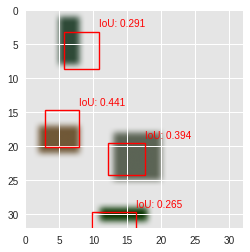

In [41]:
imgTest = (np.reshape(X_test, (dim_test, side_dim, side_dim, 3)) * np.std(imgs)) + np.mean(imgs)

# Consider a random image of our Test set
im = np.random.randint(dim_test)

# We look at the objects contained in it and the bounding boxes predicted by the algorithm
print('Test images:', im)
visual_example(imgTest[im], side_dim, N_bb, pred_bboxes[im], expe_bboxes[im])

### Valutazione dei risultati
Now we evaluate the results, first by calculating the average IoU for predictions on our Test set.

----> Datatset IoU: 0.23451219200112347
      Dim. train: 10000 examples
      Epochs: 25 - mini-batches: 16


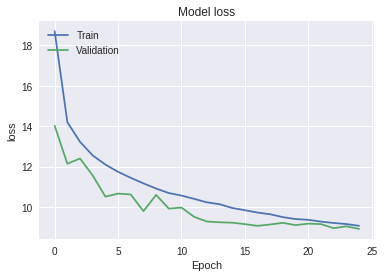

In [42]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
visual_metric(train_ex, m_iou, N_ep, Batchs, history.history, 'loss')

In [0]:
vl = history.history['val_loss']
tl = history.history['loss']

In [0]:
N_ep = 50
init_ep = 25 
Batchs = 16
optimizer = 'adadelta'
loss = euc_loss

In [45]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 26/50
10000/10000 [==============================] - 7s 687us/step - loss: 9.1872 - val_loss: 8.8998
Epoch 27/50
10000/10000 [==============================] - 7s 652us/step - loss: 8.9534 - val_loss: 8.9282
Epoch 28/50
10000/10000 [==============================] - 7s 650us/step - loss: 8.8926 - val_loss: 8.9331
Epoch 29/50
10000/10000 [==============================] - 7s 651us/step - loss: 8.8185 - val_loss: 9.0146
Epoch 30/50
10000/10000 [==============================] - 6s 650us/step - loss: 8.7784 - val_loss: 9.0297
Epoch 31/50
10000/10000 [==============================] - 6s 650us/step - loss: 8.7077 - val_loss: 8.8668
Epoch 32/50
10000/10000 [==============================] - 7s 652us/step - loss: 8.6704 - val_loss: 9.0801
Epoch 33/50
10000/10000 [==============================] - 7s 652us/step - loss: 8.6437 - val_loss: 9.0589
Epoch 34/50
10000/10000 [==============================] - 6s 650us/step - loss: 8.5688 - val_l

In [0]:
# Name will contains name of the model (181112), number of training examples in thousands (100), 
# mini-batches (16), final epoch (75)

name = '181112_' + 'tr' + str(int(train_ex/1000)) + '_mb' + str(Batchs) + '_e' + str(N_ep)
model_name = name + '.json' 
weight_name = name + '.h5'
train_history = name + '_hist'

In [47]:
# serialize weights to HDF5
model.save_weights(weight_name)
print('Saved model to disk')

# save just history
with open(train_history, 'wb') as hist:
  pickle.dump(history, hist)

Saved model to disk


In [0]:
vl += history.history['val_loss']
tl += history.history['loss']

In [0]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

----> Datatset IoU: 0.22968387213051455
      Dim. train: 10000 examples
      Epochs: 50 - mini-batches: 16


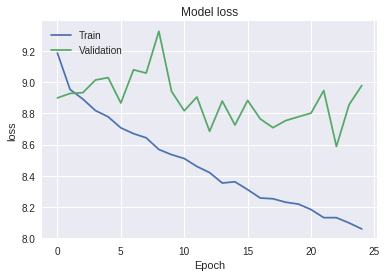

In [50]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
visual_metric(train_ex, m_iou, N_ep, Batchs, history.history, 'loss')

In [0]:
N_ep = 75
init_ep = 50 
Batchs = 16
optimizer = 'adadelta'
loss = euc_loss

In [52]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 51/75
10000/10000 [==============================] - 7s 695us/step - loss: 8.2044 - val_loss: 8.6589
Epoch 52/75
10000/10000 [==============================] - 7s 651us/step - loss: 8.0425 - val_loss: 8.7340
Epoch 53/75
10000/10000 [==============================] - 6s 649us/step - loss: 7.9928 - val_loss: 8.8224
Epoch 54/75
10000/10000 [==============================] - 7s 653us/step - loss: 7.9563 - val_loss: 8.6485
Epoch 55/75
10000/10000 [==============================] - 7s 651us/step - loss: 7.9360 - val_loss: 8.7907
Epoch 56/75
10000/10000 [==============================] - 6s 647us/step - loss: 7.8865 - val_loss: 8.5514
Epoch 57/75
10000/10000 [==============================] - 6s 650us/step - loss: 7.8715 - val_loss: 8.8382
Epoch 58/75
10000/10000 [==============================] - 7s 651us/step - loss: 7.8957 - val_loss: 8.5831
Epoch 59/75
10000/10000 [==============================] - 7s 650us/step - loss: 7.8348 - val_l

In [0]:
# Name will contains name of the model (181112), number of training examples in thousands (100), 
# mini-batches (16), final epoch (75)

name = '181112_' + 'tr' + str(int(train_ex/1000)) + '_mb' + str(Batchs) + '_e' + str(N_ep)
model_name = name + '.json' 
weight_name = name + '.h5'
train_history = name + '_hist'

In [54]:
# serialize weights to HDF5
model.save_weights(weight_name)
print('Saved model to disk')

# save just history
with open(train_history, 'wb') as hist:
  pickle.dump(history, hist)

Saved model to disk


In [0]:
vl += history.history['val_loss']
tl += history.history['loss']

In [0]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

----> Datatset IoU: 0.2627067544551271
      Dim. train: 10000 examples
      Epochs: 75 - mini-batches: 16


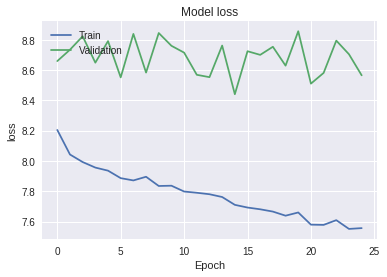

In [57]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
visual_metric(train_ex, m_iou, N_ep, Batchs, history.history, 'loss')

In [0]:
N_ep = 100
init_ep = 75 
Batchs = 16
optimizer = 'adadelta'
loss = euc_loss

In [59]:
model.compile(optimizer, loss)
history = model.fit(X_train, Y_train, epochs=N_ep, validation_data=(X_val, Y_val), batch_size=Batchs, initial_epoch = init_ep, verbose=1)

Train on 10000 samples, validate on 1250 samples
Epoch 76/100
10000/10000 [==============================] - 7s 703us/step - loss: 7.6574 - val_loss: 8.5162
Epoch 77/100
10000/10000 [==============================] - 7s 657us/step - loss: 7.5459 - val_loss: 8.6674
Epoch 78/100
10000/10000 [==============================] - 7s 655us/step - loss: 7.5224 - val_loss: 8.5607
Epoch 79/100
10000/10000 [==============================] - 7s 652us/step - loss: 7.5193 - val_loss: 8.6440
Epoch 80/100
10000/10000 [==============================] - 7s 656us/step - loss: 7.4772 - val_loss: 8.5782
Epoch 81/100
10000/10000 [==============================] - 7s 654us/step - loss: 7.4592 - val_loss: 8.7854
Epoch 82/100
10000/10000 [==============================] - 7s 654us/step - loss: 7.4447 - val_loss: 8.4776
Epoch 83/100
10000/10000 [==============================] - 7s 650us/step - loss: 7.4183 - val_loss: 8.6964
Epoch 84/100
10000/10000 [==============================] - 7s 659us/step - loss: 7.424

In [0]:
# Name will contains name of the model (181112), number of training examples in thousands (100), 
# mini-batches (16), final epoch (100)

name = '181112_' + 'tr' + str(int(train_ex/1000)) + '_mb' + str(Batchs) + '_e' + str(N_ep)
model_name = name + '.json' 
weight_name = name + '.h5'
train_history = name + '_hist'

In [61]:
# serialize weights to HDF5
model.save_weights(weight_name)
print('Saved model to disk')

# save just history
with open(train_history, 'wb') as hist:
  pickle.dump(history, hist)

Saved model to disk


In [0]:
vl += history.history['val_loss']
tl += history.history['loss']

In [0]:
# The predictions of the neural network using our Test set as input
pred_bboxes = model.predict(X_test)
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), N_bb, -1)

----> Datatset IoU: 0.2651591579740376
      Dim. train: 10000 examples
      Epochs: 100 - mini-batches: 16


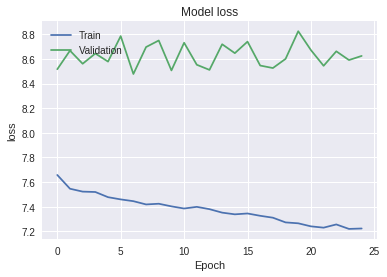

In [64]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
visual_metric(train_ex, m_iou, N_ep, Batchs, history.history, 'loss')

----> Datatset IoU: 0.2651591579740376
      Dim. train: 10000 examples
      Epochs: 100 - mini-batches: 16


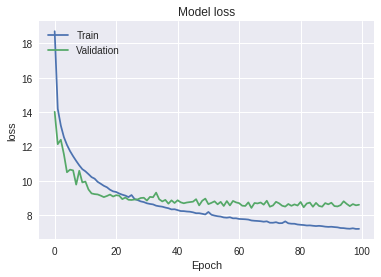

In [65]:
hist = {'val_loss': vl, 'loss': tl}
visual_metric(train_ex, m_iou, N_ep, Batchs, hist, 'loss')

Test images: 65
Object:  1
B-box confidence: 1.0
B-box coordinates: [3.59 2.44 3.66 3.95]
Object coordinates: [1.00 5.00 3.00 3.00]
Object:  2
B-box confidence: 1.0
B-box coordinates: [6.70 3.21 3.73 4.45]
Object coordinates: [7.00 3.00 3.00 3.00]
Object:  3
B-box confidence: 1.0
B-box coordinates: [5.26 8.09 4.81 4.57]
Object coordinates: [6.00 7.00 5.00 7.00]
Object:  4
B-box confidence: 1.0
B-box coordinates: [21.55 3.81 3.31 3.37]
Object coordinates: [24.00 6.00 3.00 2.00]


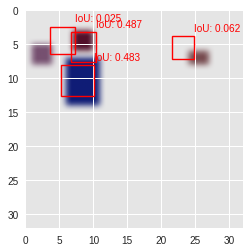

In [67]:
# Consider a random image of our Test set
im = np.random.randint(dim_test)

# We look at the objects contained in it and the bounding boxes predicted by the algorithm
print('Test images:', im)
visual_example(imgTest[im], side_dim, N_bb, pred_bboxes[im], expe_bboxes[im])